## Cognitive Battery Introduction: Jax-3DP3

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from jax3dp3.viz import save_depth_image, get_depth_image, multi_panel
from jax3dp3.transforms_3d import (
    transform_from_pos,
    depth_to_coords_in_camera
)
from jax3dp3.jax_rendering import (
    get_rectangular_prism_shape,
    render_planes_multiobject,
    batched_scorer_parallel_params,
)
from jax3dp3.likelihood import threedp3_likelihood
import jax.numpy as jnp
import jax
from scipy.spatial.transform import Rotation as R
from jax3dp3.enumerations import make_translation_grid_enumeration
from jax3dp3.viz import make_gif_from_pil_images
from PIL import Image
from IPython.display import clear_output

from tqdm import tqdm

1. Initialize camera metadata and path to data:

In [2]:
scene = "swap"
data_path = f"/home/khaledshehada/cog_jax3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [3]:
def get_camera_intrinsics(width, height, fov):
    cx, cy = width / 2.0, height / 2.0
    aspect_ratio = width / height
    fov_y = np.deg2rad(fov)
    fov_x = 2 * np.arctan(aspect_ratio * np.tan(fov_y / 2.0))
    fx = cx / np.tan(fov_x / 2.0)
    fy = cy / np.tan(fov_y / 2.0)

    return fx, fy, cx, cy

width = 300
height = 300
fov = 90

if fov:
    fx, fy, cx, cy = get_camera_intrinsics(width, height, fov)
else:
    fx = fy = cx = cy = 150

fx_fy = jnp.array([fx, fy])
cx_cy = jnp.array([cx, cy])

K = jnp.array(
    [
        [fx_fy[0], 0.0, cx_cy[0]],
        [0.0, fx_fy[1], cx_cy[1]],
        [0.0, 0.0, 1.0],
    ]
)

2. Load ground-truth RGB images, depth, and segmentation data.


In [4]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

3. Mask the depth and segmentation images to only include the relevant part of the scene (i.e. crop to the box above table).

In [5]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in range(num_frames):
    coord_image, _ = depth_to_coords_in_camera(depth_images[frame_idx], K)
    segmentation_image = seg_maps[frame_idx].copy()
    mask = np.invert(
        (coord_image[:, :, 0] < 2.0)
        * (coord_image[:, :, 0] > -1)
        * (coord_image[:, :, 1] < 0.463)
        * (coord_image[:, :, 1] > -0.8)
        * (coord_image[:, :, 2] < 1.8)
        * (coord_image[:, :, 2] > 0.25)
    )
    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

4. Pick a starting frame and initialize the object shapes and poses from that frame

In [6]:
start_t = 10
seg_img = seg_images[start_t][:, :, 2]

In [7]:
obj_ids = set()
shape_planes, shape_dims, init_poses = [], [], []
for obj_id in jnp.unique(seg_img):
    if obj_id == 0:
        continue
    obj_mask = seg_img == obj_id
    if scene == "shape" and np.sum(obj_mask) < 100:  # Only for shape, [TODO] delete or automate later
        continue    

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    center_of_box = (maxs + mins) / 2

    init_pose = transform_from_pos(center_of_box)
    init_poses.append(init_pose)

    shape, dim = get_rectangular_prism_shape(dims)
    shape_planes.append(shape)
    shape_dims.append(dim)
    obj_ids.add(obj_id.item())
shape_planes = jnp.stack(shape_planes)
shape_dims = jnp.stack(shape_dims)
init_poses = jnp.stack(init_poses)

5. Save the reconstructed depths to check that they align with the actual depths.

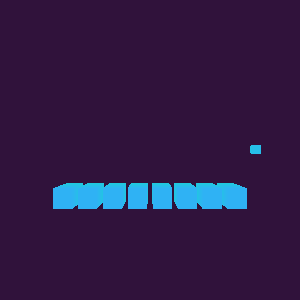

In [8]:
def render_planes_multiobject_lambda(poses):
    return render_planes_multiobject(
        poses, shape_planes, shape_dims, height, width, fx, fy, cx, cy
    )


def render_planes_multiobject_multi_lambda(poses, planes, dims):
    return render_planes_multiobject(poses, planes, dims, height, width, fx, fy, cx, cy)


render_planes_multiobject_jit = jax.jit(render_planes_multiobject_lambda)
render_planes_multiobject_multi_jit = jax.jit(render_planes_multiobject_multi_lambda)
# 4, 6, 8
reconstruction_image = render_planes_multiobject_jit(init_poses)
get_depth_image(reconstruction_image[:, :, 2], max=5.0)

6. Define the liklihood methods and the proposal enumerations.

In [9]:
# Liklihood parameters
r = radius = 0.05
outlier_prob = 0.01

# Enumeration parameters
n = 5  # number of enumerated proposals on each dimension (x, y, z).
d = 0.15  # the minimum and maximum position delta on each dimension (x, y, z).

# Liklihood methods
def likelihood(x, params):
    obs = params[0]
    rendered_image = render_planes_multiobject(
        x, shape_planes, shape_dims, height, width, fx, fy, cx, cy
    )
    weight = threedp3_likelihood(obs, rendered_image, r, outlier_prob)
    return weight


likelihood_parallel = jax.vmap(likelihood, in_axes=(0, None))
batched_scorer_parallel_jit = jax.jit(
    lambda poses, image: batched_scorer_parallel_params(
        likelihood_parallel, n, poses, (image,)
    )
)

# Enumerating proposals
enumerations = make_translation_grid_enumeration(-d, -d, -d, d, d, d, n, n, n)

7. For each frame, enumerate the positions of new object poses (currently translation only), and for each object pick the pose that maximizes the 3DP3 liklihood under a uniform prior.

In [10]:
pose_estimates = init_poses.copy()
t = start_t
gt_image = jnp.array(coord_images[t])
i = 0
enumerations_full = jnp.tile(
    jnp.eye(4)[None, :, :],
    (enumerations.shape[0], pose_estimates.shape[0], 1, 1),
)
enumerations_full = enumerations_full.at[:, i, :, :].set(enumerations)
proposals = jnp.einsum("bij,abjk->abik", pose_estimates, enumerations_full)

weights = batched_scorer_parallel_jit(proposals, gt_image)
pose_estimates = proposals[weights.argmax()]

In [11]:
num_steps = num_frames - start_t
# num_steps = 30
occlusion_threshold = 10
inferred_poses = []
pose_estimates = init_poses.copy()
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])
    n_objects = pose_estimates.shape[0]
    
    # New objects
    # seg_img = seg_images[t][:, :, 2]
    # new_init_poses, new_shape_planes, new_shape_dims = [], [], []
    # for obj_id in jnp.unique(seg_img):
    #     if obj_id.item() in obj_ids or obj_id == 0:
    #         continue
            
    #     obj_mask = seg_img == obj_id
    #     if scene == "shape" and np.sum(obj_mask) < 100:  # Only for shape, [TODO] delete or automate later
    #         continue    
        
    #     print("Found new object!")
    #     object_points = coord_images[start_t][obj_mask]
    #     maxs = np.max(object_points, axis=0)
    #     mins = np.min(object_points, axis=0)
    #     dims = maxs - mins
    #     center_of_box = (maxs + mins) / 2

    #     init_pose = transform_from_pos(center_of_box)
    #     new_init_poses.append(init_pose)

    #     shape, dim = get_rectangular_prism_shape(dims)
    #     new_shape_planes.append(shape)
    #     new_shape_dims.append(dim)
    
    # if new_init_poses:
    #     pose_estimates = jnp.concatenate((pose_estimates, new_init_poses))
    #     shape_planes = jnp.concatenate((shape_planes, new_shape_planes))
    #     shape_dims = jnp.concatenate((shape_dims, new_shape_dims))
    
    
    occluding_index = 4
    prev_pos = pose_estimates[occluding_index, :, 3:]
    apple_occluded = False
    for i in range(n_objects):
        # Occlusion detection: render depth with and without each object. If no difference, don't move object.
        if i == 2 and not apple_occluded:
            depth_with_object = render_planes_multiobject_jit(pose_estimates)
            idxs = jnp.arange(n_objects) != i
            depth_without_object = render_planes_multiobject_multi_jit(
                pose_estimates[idxs],
                shape_planes[idxs],
                shape_dims[idxs],
            )

            if (
                jnp.sum(depth_with_object[:, :, 2] != depth_without_object[:, :, 2])
                < occlusion_threshold
            ):
                apple_occluded = True
                continue

        enumerations_full = jnp.tile(
            jnp.eye(4)[None, :, :],
            (enumerations.shape[0], pose_estimates.shape[0], 1, 1),
        )
        enumerations_full = enumerations_full.at[:, i, :, :].set(enumerations)
        proposals = jnp.einsum("bij,abjk->abik", pose_estimates, enumerations_full)

        weights = batched_scorer_parallel_jit(proposals, gt_image)
        pose_estimates = proposals[weights.argmax()]
    
    if apple_occluded:
        new_pos = pose_estimates[occluding_index, :, 3:]
        apple_pos = pose_estimates[2, :, 3:]
        new_apple_pos = apple_pos + (new_pos - prev_pos)
        pose_estimates = pose_estimates.at[2, :, 3:].set(new_apple_pos)
        
        
    inferred_poses.append(pose_estimates.copy())

100%|██████████| 229/229 [18:03<00:00,  4.73s/it]


8. Get the reconstructed poses for each frame and save them as a gif file with the gt data

In [12]:
all_images = []
for t in range(start_t, start_t + num_steps):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    depth = render_planes_multiobject_jit(inferred_poses[t - start_t])
    depth = get_depth_image(depth[:, :, 2], max=5.0)
    i = 2
    apple_pose = inferred_poses[t-start_t][i].at[:3, :3].set(.4*inferred_poses[t-start_t][i][:3, :3])
    apple_pose = jnp.array([apple_pose])
    rendered_apple = render_planes_multiobject_jit(apple_pose)
    rendered_apple = get_depth_image(rendered_apple[:, :, 2], max=5.0)
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, depth, rendered_apple],
            [f"RGB Image", f"   Actual Depth", "Reconstructed Depth", "Reconstructed Reward"],
            middle_width=10,
            top_border=100,
            fontsize=20,
        )
    )
out_path = f"{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)

Saved output to: swap_out.gif
